In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

import astropy.coordinates as coord
import astropy.units as u
from pathlib import Path

from csaps import csaps

# Constants

deg2rad = np.pi/180

In [52]:
# King's profile

def f_king(r, k, rc, rt):
    
    x = (r/rc)**2
    xt = (rt/rc)**2
    f = k * ( 1/np.sqrt(1+x) - 1/np.sqrt(1+xt) )**2
        
    return f

In [53]:
# King's cumulative profile

def n_king(r, k, rc, rt):
    
    x = (r/rc)**2
    ar2 = 1 + x
    ar3 = np.sqrt( ar2 )
    xt = (rt/rc)**2
    at2 = np.sqrt( xt + 1 )    
    n_cum = np.pi * rc**2 * k * ( np.log(1+x) - 4*(ar3-1)/at2 + x/(1+xt) )
        
    return n_cum

In [4]:
cluster = pd.read_csv(r'../Data/to_0343_NGC_1502m', delimiter='\s+', skiprows=3)
# cluster.keys()

In [5]:
head = pd.read_csv(r'../Data/to_0343_NGC_1502m', delimiter='\s+', nrows=1)
# head.keys()

In [6]:
alpha = cluster['ahour'].to_numpy() * 15 * deg2rad
delta = cluster['ddeg'].to_numpy() * deg2rad
kmag  = cluster['kmag'].to_numpy()
rp    = cluster['rc'].to_numpy()

distance = head['dist'].to_numpy()

In [66]:
# Fitting options

# n_sigma_R  = 1.5
spl_smooth = 0.9
N_spl = 101

In [67]:
# Initial centre

RA_0  = 4.1305
Dec_0 = 62.331

In [68]:
# Data transformation

alpha_0 = RA_0 * 15 * deg2rad
delta_0 = Dec_0 * deg2rad

delta_alpha = alpha - alpha_0
nom = (np.sin(delta) * np.cos(delta_0) - 
        np.cos(delta) * np.sin(delta_0) * np.cos(delta_alpha))
den = (np.sin(delta) * np.sin(delta_0) + 
        np.cos(delta) * np.cos(delta_0) * np.cos(delta_alpha))
x = distance * np.cos(delta) * np.sin(delta_alpha) / den
y = distance * nom / den
R = np.sqrt(x**2 + y**2) 

Text(0.5, 1.0, 'NGC 1502 and background')

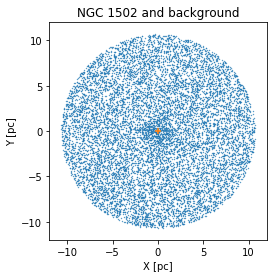

In [69]:
# Plot the stars with the limiting k_mag

kmag_min_0 = 15.5

fig = plt.figure(figsize=(5.5,4))
spec = gridspec.GridSpec(ncols=1, nrows=1)

### figure 0
ax0 = fig.add_subplot(spec[0])
bbox = 12

I = np.where( ( cluster['kmag'] < kmag_min_0 ) )[0]
ax0.scatter(x[I], y[I], marker='.', s=0.5)
ax0.scatter(0, 0, marker='+')
ax0.set_xlabel('X [pc]')
ax0.set_ylabel('Y [pc]')
ax0.set_xlim([-bbox, bbox])
ax0.set_ylim([-bbox, bbox])
ax0.set_aspect('equal', adjustable='box')
ax0.set_title('NGC 1502 and background')


In [70]:
# Initial parameters of the fit

rt = 7
rc = 1.0
k  = 100
Bgr = 93
k_tail = 0

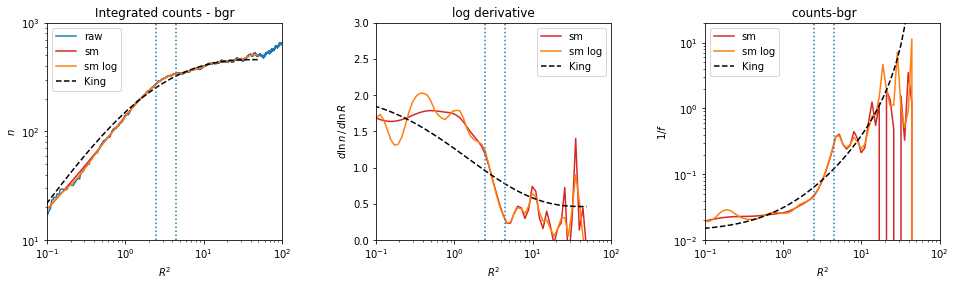

In [74]:
# Test for parameter 

fig = plt.figure(figsize=(16,4))
spec = gridspec.GridSpec(ncols=3, nrows=1, wspace=0.4)

### figure 0
ax0 = fig.add_subplot(spec[0])

# Cumulative distributions

Isort = np.argsort(R[I])
Is    = I[Isort]
n_appr = np.arange(len(I))+1 - Bgr*R[Is]**2
n_cs   = csaps(R[Is], n_appr, smooth=spl_smooth)

# spline grid

# Rs = np.linspace(min(R[Is]), max(R[Is]), N_spl)
# Us = np.log(Rs)
Us = np.linspace(np.log(min(R[Is])), np.log(rt), N_spl)
Rs = np.exp(Us)

ax0.plot( R[Is]**2, n_appr, color='tab:blue' ) # raw counts - background
ax0.plot( Rs**2, n_cs(Rs), color='tab:red' )   # raw counts - background  smoothed with spline

n_csl   = csaps(np.log(R[Is]), np.log(n_appr), smooth=0.99)  # raw counts - background  smoothed with spline in log-log
ax0.plot( Rs**2, np.exp( n_csl(Us) ), color='tab:orange' )

# King n-fit
fit_king_n = n_king(Rs, k, rc, rt)   
ax0.plot( Rs**2, fit_king_n, color='k', linestyle='dashed' )

ax0.set_xscale('log')
ax0.set_yscale('log')
ax0.set_xlim([0.1, 100])
ax0.set_ylim([1e1, 10e2])
ax0.set_title('Integrated counts - bgr')
ax0.legend(["raw", "sm", "sm log", 'King'])
ax0.set_xlabel(f"$R^2$")
ax0.set_ylabel(f"$n$")
ax0.axvline(x=2.5, linestyle='dotted')
ax0.axvline(x=4.5, linestyle='dotted')


### figure 1
ax1 = fig.add_subplot(spec[1])

# log derivatives 

ax1.plot( Rs**2, Rs*n_cs(Rs,1)/n_cs(Rs), color='tab:red' )                   # for raw counts
ax1.plot( Rs**2, n_csl(Us,1), color='tab:orange' )                # for raw counts smoothed
fk_csl   = csaps(Us, np.log(fit_king_n), smooth=0.3)
ax1.plot( Rs**2, fk_csl(Us,1), color='k', linestyle='dashed' )    # for King n-fit

ax1.set_xscale('log')
ax1.set_xlim([0.1, 100])
ax1.set_ylim([0, 3])
ax1.set_title('log derivative')
ax1.legend(['sm', 'sm log', 'King'])
ax1.set_xlabel(f"$R^2$")
ax1.set_ylabel(r"$d \ln\, n \,/\, d \ln\, R$")
ax1.axvline(x=2.5, linestyle='dotted')
ax1.axvline(x=4.5, linestyle='dotted')

### figure 2
ax2 = fig.add_subplot(spec[2])

# 1/f distributions

ax2.plot( Rs**2, 1/(n_cs(Rs,1)/2/np.pi/Rs), color='tab:red' )
dn = n_csl(Us,1) * np.exp(n_csl(Us))/Rs /2/np.pi/Rs
ax2.plot( Rs**2, 1/dn, color='tab:orange' )
fit_king = f_king(Rs, k, rc, rt)
ax2.plot( Rs**2, 1/fit_king, color='k', linestyle='dashed' )

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([0.1, 100])
ax2.set_ylim([1e-2, 20e0])
# ax2.set_ylim([1e1, 10e2])
ax2.set_title(' counts-bgr')
ax2.legend(['sm', 'sm log', 'King'])
ax2.set_xlabel(f"$R^2$")
ax2.set_ylabel(f"$1/f$")
ax2.axvline(x=2.5, linestyle='dotted')
ax2.axvline(x=4.5, linestyle='dotted')

# ---

fname = "NGC_1502_image1.png"
fig.savefig(fname, bbox_inches='tight')

(array([ 46.,  56.,  55.,  71.,  74.,  84.,  96., 119., 111., 133., 143.,
        159., 178., 197., 236., 253., 321., 327., 255., 146.]),
 array([13.001  , 13.15065, 13.3003 , 13.44995, 13.5996 , 13.74925,
        13.8989 , 14.04855, 14.1982 , 14.34785, 14.4975 , 14.64715,
        14.7968 , 14.94645, 15.0961 , 15.24575, 15.3954 , 15.54505,
        15.6947 , 15.84435, 15.994  ]),
 <a list of 20 Patch objects>)

<Figure size 432x288 with 0 Axes>

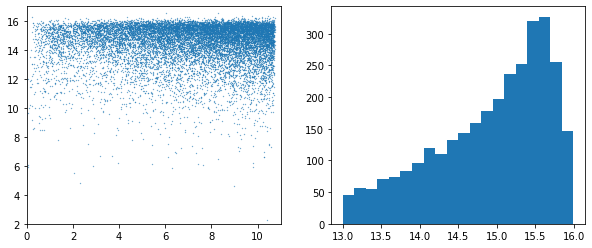

In [15]:
fig = plt.figure()

fig = plt.figure(figsize=(10,4))
spec = gridspec.GridSpec(ncols=2, nrows=1)

### figure 0
ax0 = fig.add_subplot(spec[0])
ax0.scatter(R, kmag, marker='.', s=0.3)
ax0.set_xlim([0, 11])
ax0.set_ylim([2, 17])

### figure 1
Ic = np.where( ( kmag > 13 ) & 
               ( kmag < 16 ) &  
               ( R > 6 )     &  
               ( R < 8 )  )[0]

ax1 = fig.add_subplot(spec[1])
# ax1.scatter(rp*distance*deg2rad, kmag, marker='.', s=0.5)
ax1.hist(kmag[Ic], bins=20)


In [16]:
# Initial conditions for walkers

np.random.seed(42)

Nwalkers = 16
Ndim     = 8       # number of parameters to define

mean_X    = np.array([  rt,   rc,   k,   RA_0,  Dec_0,   kmag_min_0,  Bgr,  k_tail])
std_X     = np.array([ 1.0, 0.50, 25.0,  0.01,   0.1,         0.001,  1.0,  5.0])
weight_X  = np.ones(Ndim) *1e-2

p0 = np.zeros( (Nwalkers, Ndim), dtype=np.float )
for ip in range(Ndim):        
    for iw in range(Nwalkers):
        p0[iw][ip] = mean_X[ip] + 6*std_X[ip] * (np.random.rand(1)-0.5)

In [17]:
labels = [r"$r_t$", "$r_c$", "$k$", "$RA_0$", "$dec_0$", "$k_{mag}$", "$Bgr$", "$k_{tail}$"]
labels += ["log prob", "log prior"]

In [ ]:
# The likelyhood function

def log_prob(X):   

    alpha_0 = X[3] * 15 * deg2rad
    delta_0 = X[4] * deg2rad

    delta_alpha = alpha - alpha_0
    nom = (np.sin(delta) * np.cos(delta_0) - 
        np.cos(delta) * np.sin(delta_0) * np.cos(delta_alpha))
    den = (np.sin(delta) * np.sin(delta_0) + 
        np.cos(delta) * np.cos(delta_0) * np.cos(delta_alpha))
    x = distance * np.cos(delta) * np.sin(delta_alpha) / den
    y = distance * nom / den
    R = np.sqrt(x**2 + y**2)  
    
    I_R = np.where( kmag < X[5] )[0]         
    r = R[I_R]
    r.sort()
    
    # print("X[0]=",X[0])
    
    n = np.arange(len(r)) + 1
    n_appr = n - X[6]*r**2
    
    n_cs   = csaps(r, n_appr, smooth=spl_smooth)
    rs = np.linspace(min(r), max(r), N_spl)
    f_app = n_cs(rs,1)    
    f_app[np.where( (f_app < 0) )[0]] = 1e-30
    
    fit_king = f_king(rs, X[2], X[1], X[0]) + X[7]
    # print(fit_king)
    
    if show_plot:
        fig = plt.figure(figsize=(7, 4.5))
        ax = fig.add_subplot(111)
        ax.plot(rs, np.log( f_app ))
        ax.plot(rs, np.log( fit_king ))
        ax.set_title('King diff to (counts-bgr)')
        ax.legend(['Apparent', 'King fit + tail'])
        ax.set_xlim([0, 10])
        ax.set_ylim([-2, 10])

        
    del_f  = np.log( f_app ) - np.log( fit_king )        
    log_lh = -np.sum((del_f)**2)/N_spl
    
    # print('log_lh =', log_lh)
    
    if( np.isnan(log_lh) ):
        log_lh = -np.inf
    
    
#   log of the prior 

    lh_prior = 0
    for jp in range(Ndim):
        bias = (X[jp] - mean_X[jp]) ** 2 / std_X[jp]**2;
    
        if (bias > 9.01):
            lf_jp = np.inf;
        else:
            lf_jp = bias * weight_X[jp];
    
        lh_prior += lf_jp;

    # print('lh_prior =', lh_prior)
    
    log_lh -= lh_prior;
    
    return float(log_lh)



In [ ]:
import time

show_plot = 0
start = time.time()
ni=16
lf=0
for j in range(ni):
    lf+=log_prob(p0[j])
end = time.time()
lf/=ni

print((end - start)/ni)
print(lf)

In [ ]:
show_plot=1
log_prob(mean_X - 3*std_X)
show_plot=0

In [ ]:
import emcee
from multiprocessing import Pool

pool = Pool(processes=int(Nwalkers/4))
sampler = emcee.EnsembleSampler(Nwalkers, Ndim, log_prob, pool=pool)

In [ ]:
# Burn-in
show_plot = 0
start = time.time()
state = sampler.run_mcmc(p0, 100)
sampler.reset()
end = time.time()
print(end - start)

In [ ]:
# MCMC call

max_n = 100000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

# Now we'll sample for up to max_n steps
for sample in sampler.sample(state, iterations=max_n, progress=True):
    # Only check convergence every 100 steps
    if sampler.iteration % 100:
        continue

    # Compute the autocorrelation time so far
    # Using tol=0 means that we'll always get an estimate even
    # if it isn't trustworthy
    tau = sampler.get_autocorr_time(tol=0)
    autocorr[index] = np.mean(tau)
    index += 1

    # Check convergence
    converged = np.all(tau * 100 < sampler.iteration)
    converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
    if converged:
        break
    old_tau = tau

In [ ]:
#  Show individual distributions
#  rt,    rc,     k,   RA_0,   dec_0,   kmag,    Bgr,   k_tail

j=7
samples = sampler.get_chain(flat=True)
plt.hist(samples[:,j], 60, color="k", histtype="step")
plt.xlabel(labels[j])
plt.ylabel(r"p(" + labels[j] +r")")
plt.gca().set_yticks([]);

In [ ]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

In [ ]:
n = 100 * np.arange(1, index + 1)
y = autocorr[:index]
plt.plot(n, n / 100.0, "--k")
plt.plot(n, y)
plt.xlim(0, n.max())
plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

In [ ]:
# Corner diagram

import corner

tau = sampler.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
# print("flat log prior shape: {0}".format(log_prior_samples.shape))

all_samples = np.concatenate(
    (samples, log_prob_samples[:, None]), axis=1
)

'''
all_samples = np.concatenate(
    (samples, log_prob_samples[:, None], log_prior_samples[:, None]), axis=1
)
'''

# labels = list(map(r"$\theta_{{{0}}}$".format, range(1, Ndim + 1)))

corner.corner(all_samples, labels=labels, truths=np.append(mean_X[:], np.array([0.0])) );

In [ ]:
from IPython.display import display, Math

X_opt = np.zeros( Ndim, dtype=np.float )

for i in range(Ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))
    X_opt[i] = mcmc[1]

show_plot = 1
log_prob(X_opt)

In [ ]:
for i in range(Ndim):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{0:7.3f}    -{1:6.3f}    {2:6.3f}"
    txt = txt.format(mcmc[1], q[0], q[1])
    display(txt)